Shape of the dataset: (100, 4)

Missing values in each column:
Customer ID       0
Age               0
Annual Income     0
Spending Score    0
dtype: int64

Number of duplicate rows: 0

Data types of each column:
Customer ID       int64
Age               int64
Annual Income     int64
Spending Score    int64
dtype: object

Summary statistics:
       Customer ID         Age  Annual Income  Spending Score
count   100.000000  100.000000     100.000000       100.00000
mean     50.500000   36.280000   69090.000000        47.28000
std      29.011492   12.109834   48295.825572        28.17194
min       1.000000   19.000000   12000.000000         1.00000
25%      25.750000   29.000000   17750.000000        17.00000
50%      50.500000   35.000000   72000.000000        49.00000
75%      75.250000   39.250000  120000.000000        73.25000
max     100.000000   80.000000  150000.000000        99.00000
   Customer ID       Age  Annual Income  Spending Score
0    -1.714816 -1.102154      -1.125615   

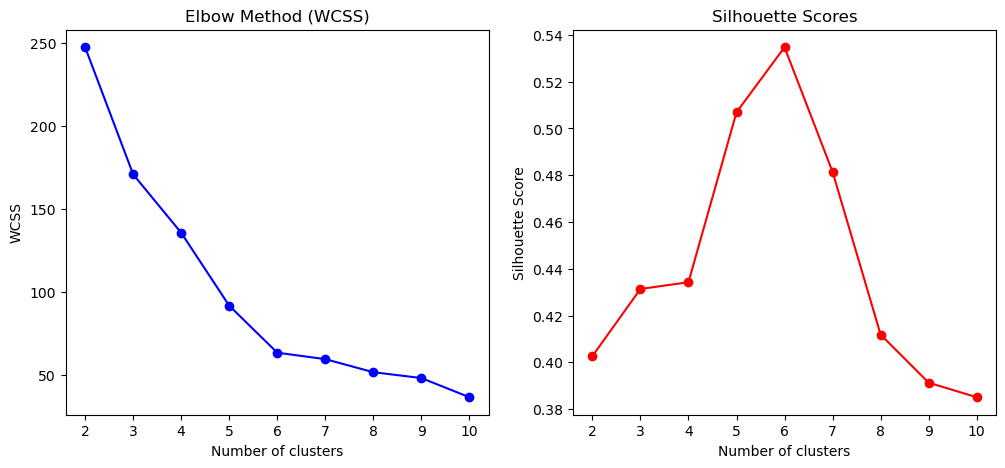

Cluster
1    53
2    25
0    22
Name: count, dtype: int64


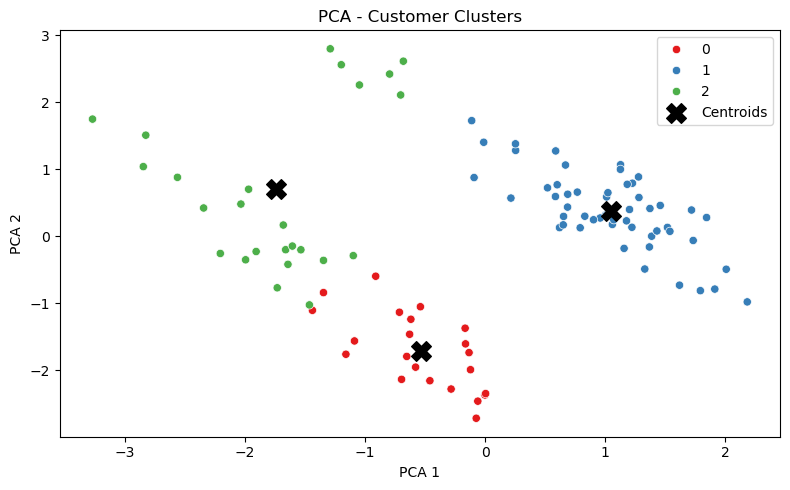

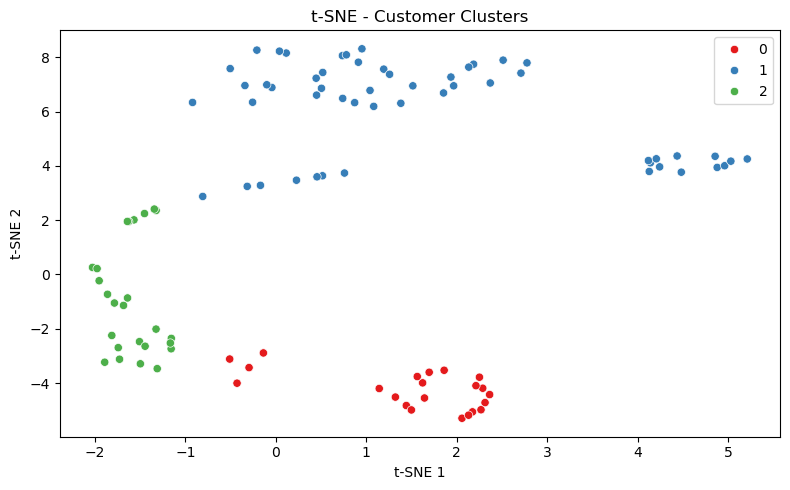

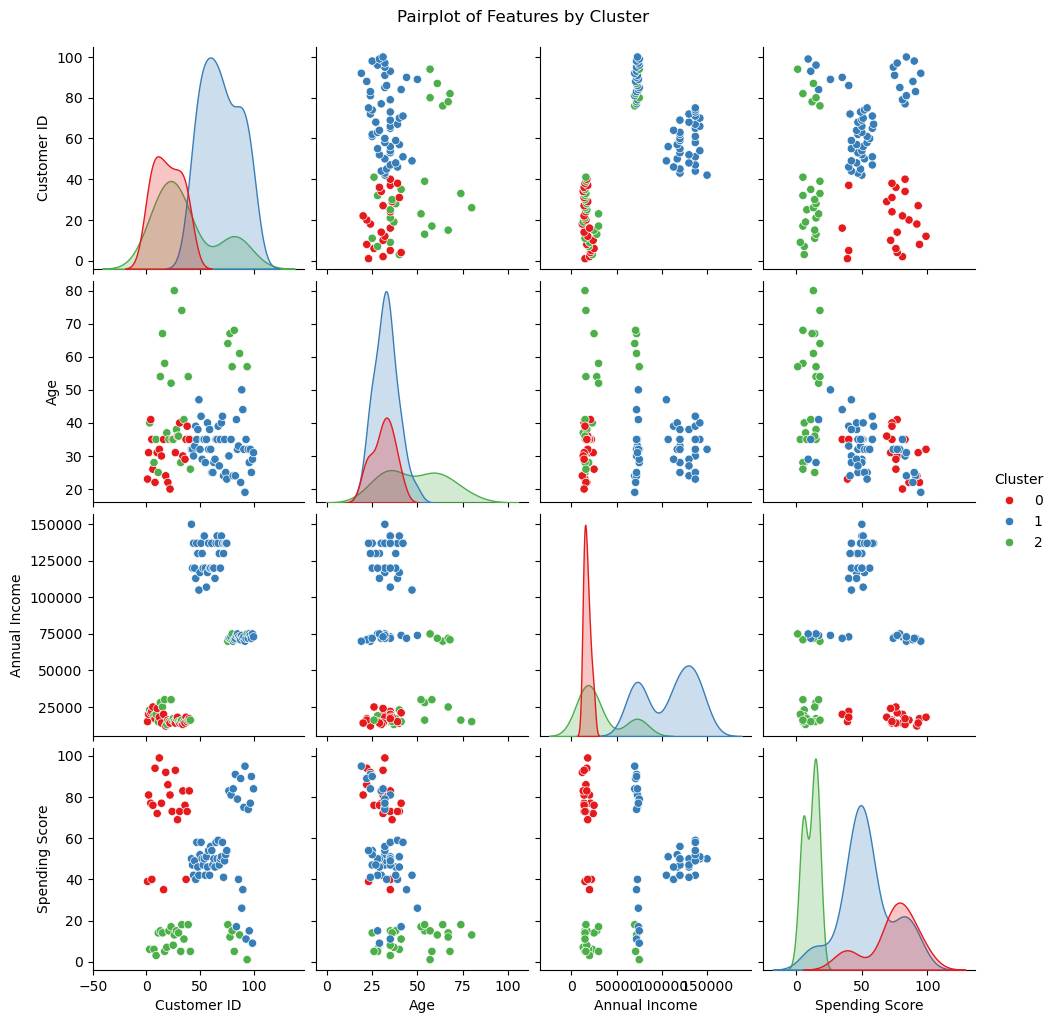

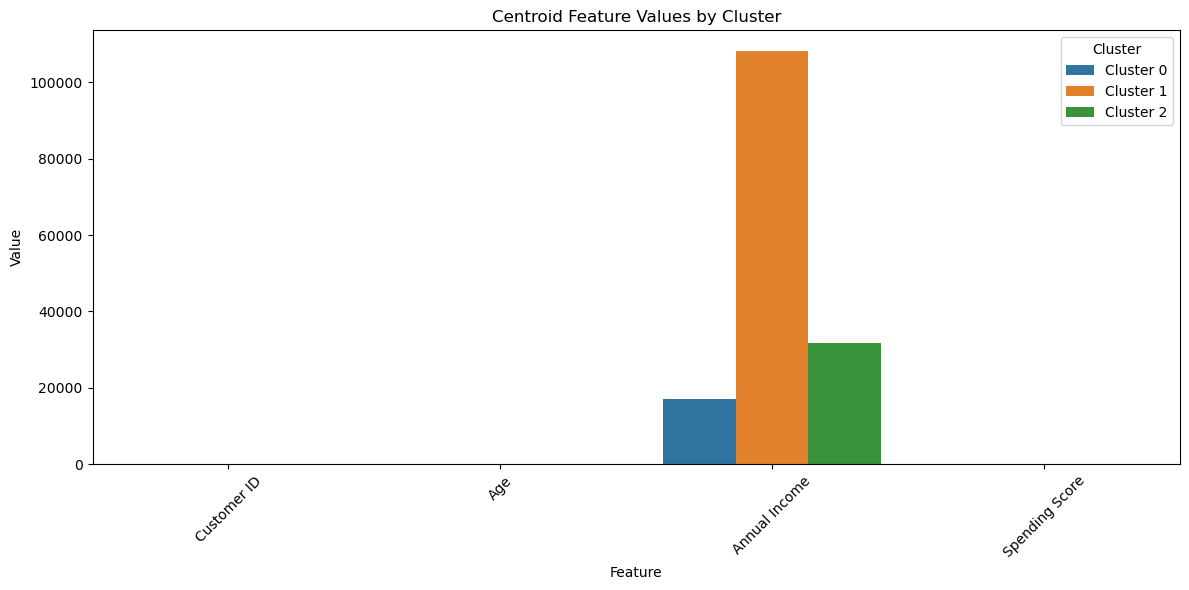

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('Downloads/customer_data.csv')

# Inspect the dataset
print("Shape of the dataset:", df.shape)
print("\nMissing values in each column:")
print(df.isnull().sum())
print("\nNumber of duplicate rows:", df.duplicated().sum())
print("\nData types of each column:")
print(df.dtypes)

# Summary statistics
print("\nSummary statistics:")
print(df.describe(include='all'))

# Select numeric columns only for scaling
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Data Preprocessing
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numeric columns
df_scaled = df.copy()  # To keep original data intact
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Display the first few rows of the scaled data
print(df_scaled.head())

#Data Clustering
# Use scaled numeric data for clustering
X = df_scaled[numeric_cols]

# Elbow Method: calculate WCSS for different cluster counts
wcss = []
silhouette_scores = []
cluster_range = range(2, 11)  # Typically from 2 to 10 clusters

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot WCSS (Elbow Method)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, wcss, 'bo-')
plt.title('Elbow Method (WCSS)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, 'ro-')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.show()

# Choose optimal clusters (example: based on visual inspection, assume k=3)
optimal_k = 3

# Apply K-Means with optimal clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
df_scaled['Cluster'] = kmeans_optimal.fit_predict(X)

# Show cluster assignment counts
print(df_scaled['Cluster'].value_counts())

# Data Visualization
numeric_df = df.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

# KMeans
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_scaled)
df['Cluster'] = labels
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# PCA Scatter Plot
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=labels, palette='Set1', legend='full')
plt.title('PCA - Customer Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.scatter(
    pca.transform(scaler.transform(centroids))[:, 0],
    pca.transform(scaler.transform(centroids))[:, 1],
    marker='X', s=200, c='black', label='Centroids'
)
plt.legend()
plt.tight_layout()
plt.show()

# t-SNE Scatter Plot
if X_scaled.shape[0] > 30:  # t-SNE perplexity default is 30; adjust or skip for small samples
    tsne = TSNE(n_components=2, random_state=42)
    tsne_components = tsne.fit_transform(X_scaled)
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=tsne_components[:, 0], y=tsne_components[:, 1], hue=labels, palette='Set1', legend='full')
    plt.title('t-SNE - Customer Clusters')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    # Centroids not generally recommended for t-SNE, but if needed:
    # c_tsne = tsne.fit_transform(scaler.transform(centroids))
    # plt.scatter(c_tsne[:, 0], c_tsne[:, 1], marker='X', s=200, c='black', label='Centroids')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Pair Plot
sns.pairplot(df, hue='Cluster', palette='Set1', diag_kind='kde')
plt.suptitle('Pairplot of Features by Cluster', y=1.02)
plt.show()

# Centroid Visuals
centroid_df = pd.DataFrame(centroids, columns=numeric_df.columns)
centroid_df['Cluster'] = [f'Cluster {i}' for i in range(n_clusters)]
centroid_plot = centroid_df.melt(id_vars='Cluster', var_name='Feature', value_name='Value')
plt.figure(figsize=(12, 6))
sns.barplot(data=centroid_plot, x='Feature', y='Value', hue='Cluster')
plt.title('Centroid Feature Values by Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()